In [ ]:
import os
import gc
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zillow.analysis.data_wrangling import find_adv_missing_per_col, find_missing_corrs_per_col, split_rp_from_miss_corr_df, plot_miss_corrs
from zillow.dataclasses.data_wrangling import WranglingColumnsConfig
from zillow.config.feature_engineering import FeaturesDtypeConversionConfig_v1
from zillow.utils.common import read_data, find_shared_cols, find_unshared_cols
from zillow.config.config import load_config_no_wrap, create_config_from_dict, merge_configs
from zillow.config.paths import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, REPORTS_DIR, ANALYSIS_RESULTS_DIR


cfg = load_config_no_wrap('default')
cur_cfg = create_config_from_dict({
    'load_all_data': False,
    'main_train_path': INTERIM_DATA_DIR / 'cleaned_train_2016_v1.0.parquet',
})
cfg = merge_configs(cfg, cur_cfg)

np.random.seed(cfg.RSEED)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

zillow_dictionary = pd.read_csv(RAW_DATA_DIR / "zillow_data_dictionary.csv")

if cfg.to_load_all_data:
    properties_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2016_v1.0.parquet", dtype='default')
    properties_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2017_v1.0.parquet", dtype='default')
    train_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2016_v1.0.parquet", dtype='default')
    train_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2017_v1.0.parquet", dtype='default')

train = read_data(cfg.main_train_path, dtype='default')

wrangling_cols = WranglingColumnsConfig()
features_dtype_cfg = FeaturesDtypeConversionConfig_v1()


In [3]:
cat_train = train.select_dtypes(include='category')
cat_train.columns, cat_train.shape

(Index(['fips', 'propertycountylandusecode', 'propertyzoningdesc',
        'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
        'raw_census_fips', 'raw_census_main_id', 'raw_census_suffix_id',
        'raw_census_group_id', 'raw_census_group_number_id', 'census_fips',
        'census_main_id', 'census_suffix_id', 'census_group_id',
        'census_group_number_id'],
       dtype='object'),
 (90026, 17))

In [4]:
for c in cat_train:
    print(f"Column: {c}. Unique: {cat_train[c].nunique()}. Type: {cat_train[c].dtype.categories.dtype}. ")

Column: fips. Unique: 3. Type: float64. 
Column: propertycountylandusecode. Unique: 77. Type: object. 
Column: propertyzoningdesc. Unique: 1994. Type: object. 
Column: regionidcity. Unique: 177. Type: float64. 
Column: regionidcounty. Unique: 3. Type: float64. 
Column: regionidneighborhood. Unique: 493. Type: float64. 
Column: regionidzip. Unique: 388. Type: float64. 
Column: raw_census_fips. Unique: 3. Type: float64. 
Column: raw_census_main_id. Unique: 1409. Type: Int16. 
Column: raw_census_suffix_id. Unique: 60. Type: float64. 
Column: raw_census_group_id. Unique: 10. Type: float64. 
Column: raw_census_group_number_id. Unique: 344. Type: Int16. 
Column: census_fips. Unique: 4. Type: float64. 
Column: census_main_id. Unique: 1403. Type: Int16. 
Column: census_suffix_id. Unique: 60. Type: float64. 
Column: census_group_id. Unique: 9. Type: float64. 
Column: census_group_number_id. Unique: 243. Type: Int16. 


In [5]:
for c in train[list(features_dtype_cfg.dtype_break_down_mapping['censuses'].keys())]:
    print(f"Column: {c}. Unique: {train[c].nunique()}. Type: {train[c].dtype}. ")

Column: raw_census_fips. Unique: 3. Type: category. 
Column: raw_census_main_id. Unique: 1409. Type: category. 
Column: raw_census_suffix_id. Unique: 60. Type: category. 
Column: raw_census_group_id. Unique: 10. Type: category. 
Column: raw_census_group_number_id. Unique: 344. Type: category. 
Column: census_fips. Unique: 4. Type: category. 
Column: census_main_id. Unique: 1403. Type: category. 
Column: census_suffix_id. Unique: 60. Type: category. 
Column: census_group_id. Unique: 9. Type: category. 
Column: census_group_number_id. Unique: 243. Type: category. 


<Axes: >

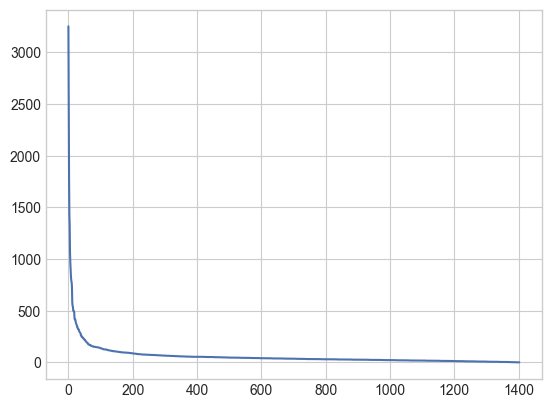

In [6]:
sns.lineplot(train['census_main_id'].value_counts().values)

In [7]:
zillow_dictionary[zillow_dictionary['feature'].isin(cat_train.columns)][['feature', 'description']]

,feature,description
17,fips,Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details
35,propertycountylandusecode,County land use code i.e. it's zoning at the county level
37,propertyzoningdesc,Description of the allowed land uses (zoning) for that property
40,regionidcounty,County in which the property is located
41,regionidcity,City in which the property is located (if any)
42,regionidzip,Zip code in which the property is located
43,regionidneighborhood,Neighborhood in which the property is located


In [8]:
for c in cat_train:
    if cat_train[c].dtype.categories.dtype == 'object':
        print(c, cat_train[c].value_counts().index[:100])

propertycountylandusecode CategoricalIndex(['0100', '122', '010C', '0101', '34', '1111', '1', '010E',
                  '010D', '0200', '1129', '1110', '0400', '0300', '012C',
                  '1128', '0104', '01DC', '010V', '01HC', '38', '0103', '96',
                  '010G', '010H', '010M', '0700', '1210', '1117', '0108',
                  '0201', '135', '1014', '1222', '010F', '0109', '1410',
                  '1116', '73', '012E', '1720', '070D', '1321', '040V', '1112',
                  '100V', '1310', '105', '0401', '0110', '020G', '012D',
                  '0102', '1012', '030G', '1432', '1421', '1011', '1420',
                  '8800', '6050', '0111', '200', '1722', '0114', '0130',
                  '1333', '0131', '01DD', '020M', '0210', '1200', '0301',
                  '0303', '010', '040A', '0'],
                 categories=['0', '010', '0100', '0101', ..., '6050', '73', '8800', '96'], ordered=False, dtype='category', name='propertycountylandusecode')
propertyzoningdesc C

#### Fips

In [9]:
cat_train.columns

Index(['fips', 'propertycountylandusecode', 'propertyzoningdesc',
       'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
       'raw_census_fips', 'raw_census_main_id', 'raw_census_suffix_id',
       'raw_census_group_id', 'raw_census_group_number_id', 'census_fips',
       'census_main_id', 'census_suffix_id', 'census_group_id',
       'census_group_number_id'],
      dtype='object')

In [10]:
fips_cols = ['fips', 'census_fips', 'raw_census_fips']

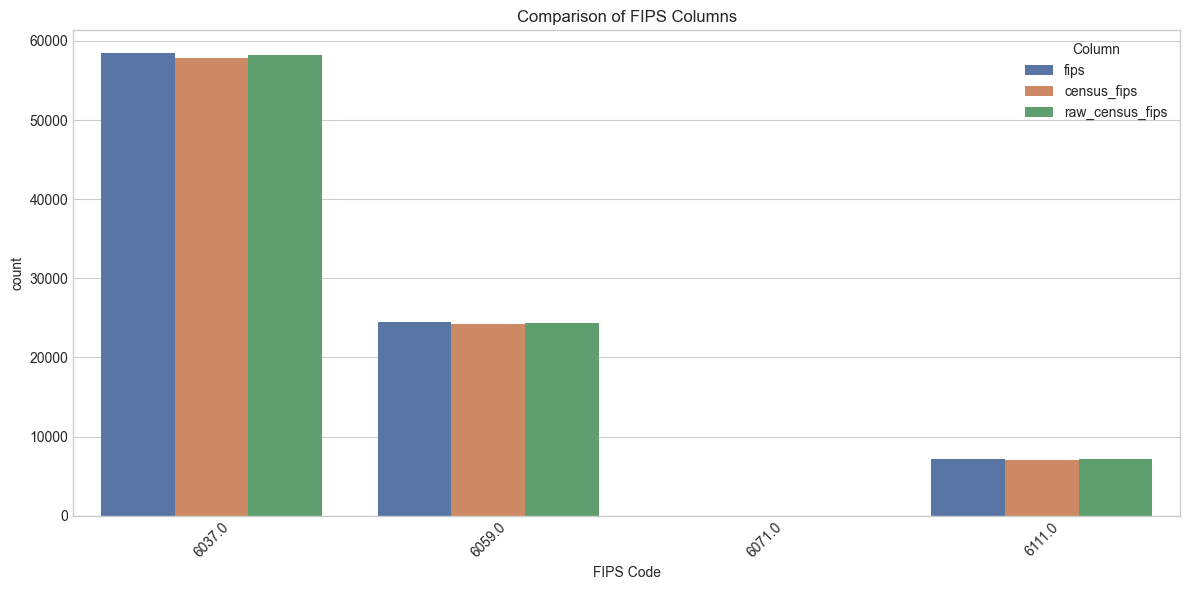

In [11]:
comp_df = pd.DataFrame({
    'fips': cat_train['fips'].value_counts().sort_index(),
    'census_fips': cat_train['census_fips'].value_counts().sort_index(),
    'raw_census_fips': cat_train['raw_census_fips'].value_counts().sort_index(),
}).fillna(0).reset_index()

comp_long = comp_df.melt(id_vars='index', var_name='column', value_name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='count', hue='column', data=comp_long)
plt.title('Comparison of FIPS Columns')
plt.xlabel('FIPS Code')
plt.xticks(rotation=45)
plt.legend(title='Column')
plt.tight_layout()

In [12]:
cat_train['census_fips'].unique()

[6111.0, 6037.0, 6059.0, NaN, 6071.0]
Categories (4, float64): [6037.0, 6059.0, 6071.0, 6111.0]

In [13]:
print(comp_df[comp_df['index'] == 6071])
cat_train['census_fips'] = cat_train['census_fips'].apply(lambda x: np.nan if x == 6071 else x)
print(cat_train[cat_train['census_fips'] == 6071].shape)

    index  fips  census_fips  raw_census_fips
2  6071.0   0.0            6              0.0
(0, 17)


In [14]:
other_fips = ['fips', 'census_fips']
raw_fips_none = cat_train.loc[cat_train['raw_census_fips'].isna(), other_fips]
raw_fips_none[:10]

,fips,census_fips
90026,6037.0,NaN
90027,6037.0,NaN
90028,6037.0,NaN
90029,6037.0,NaN
90030,6037.0,NaN
90031,6037.0,NaN
90032,6037.0,NaN
90033,6037.0,NaN
90034,6037.0,NaN
90035,6037.0,NaN


In [15]:
cat_train[cat_train['raw_census_fips'] != cat_train['census_fips']].head()

,fips,propertycountylandusecode,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,raw_census_fips,raw_census_main_id,raw_census_suffix_id,raw_census_group_id,raw_census_group_number_id,census_fips,census_main_id,census_suffix_id,census_group_id,census_group_number_id
430,6037.0,010D,EMR2*,51861.0,3101.0,NaN,96479.0,6037.0,4333,NaN,NaN,42,NaN,NaN,NaN,NaN,NaN
433,6059.0,1,NaN,52650.0,1286.0,403197.0,96954.0,6059.0,524,26.0,2.0,52,NaN,NaN,NaN,NaN,NaN
434,6037.0,100V,LARD6,12447.0,3101.0,46795.0,96451.0,6037.0,1242,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN
881,6037.0,0100,AHRS-2-200,9840.0,3101.0,764088.0,96336.0,6037.0,5429,0.0,1.0,6,NaN,NaN,NaN,NaN,NaN
888,6059.0,1,NaN,52650.0,1286.0,403197.0,96952.0,6111.0,56,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN


In [16]:
un_equal_fips = cat_train[
    (cat_train['fips'].astype(str) != cat_train['census_fips'].astype(str)) |
    (cat_train['fips'].astype(str) != cat_train['raw_census_fips'].astype(str))
][fips_cols]

print(f"{un_equal_fips.shape[0]} samples with unequal fips.")
un_equal_fips.sample(1000).head()

46015 samples with unequal fips.


,fips,census_fips,raw_census_fips
82394,6037.0,6111.0,6111.0
43416,6037.0,6059.0,6059.0
50051,6111.0,6037.0,6037.0
85138,6059.0,6037.0,6037.0
26053,6059.0,6111.0,6111.0


#### Census vs raw census

In [17]:
census_train = train[train.columns[train.columns.str.startswith('census_')]].copy()
raw_census_train = train[train.columns[train.columns.str.startswith('raw_census_')]].copy()

census_train.columns, raw_census_train.columns

(Index(['census_fips', 'census_main_id', 'census_suffix_id', 'census_group_id',
        'census_group_number_id'],
       dtype='object'),
 Index(['raw_census_fips', 'raw_census_main_id', 'raw_census_suffix_id',
        'raw_census_group_id', 'raw_census_group_number_id'],
       dtype='object'))

In [18]:
for cens in census_train.columns:
    print(cens)
    title = cens.replace('census_', '')
    rawc = 'raw_' + cens
    un_equal_raw_census = cat_train.loc[cat_train[rawc].astype(str) != cat_train[cens].astype(str), [rawc, cens]]
    print(f"{un_equal_raw_census.shape[0]} samples with unequal {title} in raw vs census.")
    print(f"{un_equal_raw_census.dropna().shape[0]} not missing samples with unequal {title} in raw vs census.")
    print_separation_line()
    

census_fips
621 samples with unequal fips in raw vs census.
14 not missing samples with unequal fips in raw vs census.

 ------------------------------ 

census_main_id
1198 samples with unequal main_id in raw vs census.
350 not missing samples with unequal main_id in raw vs census.

 ------------------------------ 

census_suffix_id
9265 samples with unequal suffix_id in raw vs census.
381 not missing samples with unequal suffix_id in raw vs census.

 ------------------------------ 

census_group_id
14079 samples with unequal group_id in raw vs census.
349 not missing samples with unequal group_id in raw vs census.

 ------------------------------ 

census_group_number_id
17242 samples with unequal group_number_id in raw vs census.
16385 not missing samples with unequal group_number_id in raw vs census.

 ------------------------------ 



#### Region features

In [19]:
region_cols = cat_train.columns[cat_train.columns.str.startswith('region')]
region_df = cat_train[region_cols].astype(float)
region_df.head()

,regionidcity,regionidcounty,regionidneighborhood,regionidzip
0,34543.0,2061.0,NaN,97081.0
1,34543.0,2061.0,NaN,97083.0
2,26965.0,2061.0,NaN,97113.0
3,26965.0,2061.0,NaN,97113.0
4,34543.0,2061.0,NaN,97084.0


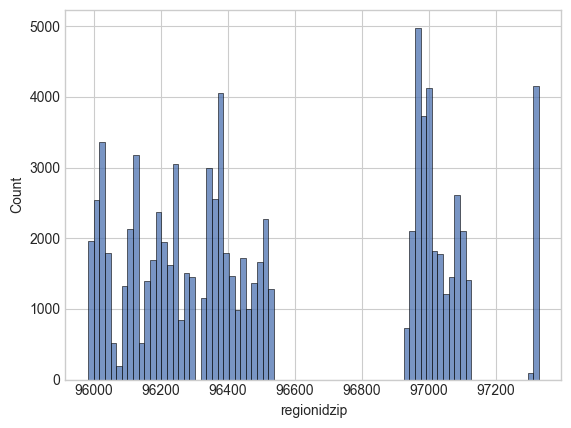

In [20]:
sns.histplot(x=region_df['regionidzip'].clip(upper=region_df['regionidzip'].quantile(0.99)), bins=80);

#### Cardinality

In [30]:
def compute_df_cardinality(df):
    path = ANALYSIS_RESULTS_DIR + 'cat_feats_cardinality.csv'
    if os.path.exists(path):
        return pd.read_csv(path, index_col='column')
    
    rows = []
    for col in cat_train.columns:
        not_na   = cat_train[col].count()
        uniq     = cat_train[col].nunique()
        sampl_unique_rat = not_na / uniq

        # percentage of total samples. Used to calculate cardinality
        pct       = 1  
        accept_ct = not_na * pct / 100
        low_ct    = (cat_train[col].value_counts() < accept_ct).sum()
        rows.append({
            'column':            col,
            'not_na_count':      not_na,
            'nunique':           uniq,
            'samples_unique_ratio':      sampl_unique_rat,
            'accepted_count':    round(accept_ct,0),
            'low_freq_nunique':   low_ct,
            'low_freq_ratio':    low_ct/uniq
        })

    result_df = pd.DataFrame(rows).set_index('column').round(2)
    result_df.to_csv(path)
    return result_df

result_df = compute_df_cardinality(cat_train)
display(result_df)

,not_na_count,nunique,samples_unique_ratio,accepted_count,low_freq_nunique,low_freq_ratio
column,,,,,,
fips,90026,3,30008.67,900.0,0,0.00
propertycountylandusecode,90025,77,1169.16,900.0,65,0.84
propertyzoningdesc,58152,1994,29.16,582.0,1982,0.99
regionidcity,88227,177,498.46,882.0,154,0.87
regionidcounty,90026,3,30008.67,900.0,0,0.00
regionidneighborhood,35900,493,72.82,359.0,470,0.95
regionidzip,89991,388,231.94,900.0,386,0.99
raw_census_fips,89779,3,29926.33,898.0,0,0.00
raw_census_main_id,89779,1409,63.72,898.0,1402,1.00


In [28]:
cat_train['propertyzoningdesc'].value_counts().head(25)

propertyzoningdesc
LAR1       7654
LAR3       2795
LARS       1497
LBR1N      1453
LARD1.5    1303
LAR2       1287
SCUR2      1102
LARD2       959
LARA        851
LARE11      712
TORR-LO     616
LARE15      615
LCR1YY      528
LAR4        503
SCUR3       492
PSR6        441
LARD3       427
LKR1YY      401
GLR1YY      335
PDR1*       326
LCA11*      325
LCR1*       311
LAC2        306
LCA22*      306
LCA25*      288
Name: count, dtype: int64